In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU, Dropout,
                                     MaxPooling1D, GlobalAveragePooling1D, Dense, Add)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# === Load CSVs ===
signal_bbh = pd.read_csv("./injected-dataset/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
noise = pd.read_csv("./injected-dataset/Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)
#val_signal_bbh = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
#val_noise = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)

signal_bbh["label"] = 1
noise["label"] = 0
#val_signal_bbh["label"] = 1
#val_noise["label"] = 0

# === Merge, Shuffle, Scale ===
train_data = shuffle(pd.concat([signal_bbh, noise], axis=0).reset_index(drop=True), random_state=42)
#val_data = shuffle(pd.concat([val_signal_bbh, val_noise], axis=0).reset_index(drop=True), random_state=42)

X = train_data.iloc[:,:-1].values
y = train_data["label"].values.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
scaler.fit(noise.iloc[:, :-1].values)
np.save("scaler_mean.npy", scaler.mean_)
np.save("scaler_scale.npy", scaler.scale_)

X_train = scaler.transform(X_train)
#y_train = train_data.iloc[:, -1].values.astype(np.float32)

X_val = scaler.transform(X_val)
#y_val = val_data.iloc[:, -1].values.astype(np.float32)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [7]:
def build_strong_cnn(input_shape):
    model = Sequential([
        Conv1D(64, 16, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 8, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(256, 8, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),

        Conv1D(512, 4, activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling1D(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


X_debug = np.concatenate([X_train[y_train==1][:100], X_train[y_train==0][:100]])
y_debug = np.concatenate([y_train[y_train==1][:100], y_train[y_train==0][:100]])

model = build_strong_cnn(X_debug.shape[1:])
model.fit(X_debug, y_debug, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
13/13 [==============================] - 9s 349ms/step - loss: 0.7937 - accuracy: 0.4550
Epoch 2/20
13/13 [==============================] - 5s 349ms/step - loss: 0.7695 - accuracy: 0.5000
Epoch 3/20
13/13 [==============================] - 5s 358ms/step - loss: 0.6997 - accuracy: 0.4650
Epoch 4/20
13/13 [==============================] - 2s 137ms/step - loss: 0.7137 - accuracy: 0.5200
Epoch 5/20
13/13 [==============================] - 2s 135ms/step - loss: 0.6880 - accuracy: 0.5700
Epoch 6/20
13/13 [==============================] - 3s 209ms/step - loss: 0.6899 - accuracy: 0.5600
Epoch 7/20
13/13 [==============================] - 2s 136ms/step - loss: 0.7042 - accuracy: 0.5750
Epoch 8/20
13/13 [==============================] - 2s 136ms/step - loss: 0.6899 - accuracy: 0.5650
Epoch 9/20
13/13 [==============================] - 2s 137ms/step - loss: 0.6590 - accuracy: 0.6450
Epoch 10/20
13/13 [==============================] - 2s 137ms/step - loss: 0.6852 - accuracy: 0.5850

Epoch 1/30
216/216 [==============================] - 22s 82ms/step - loss: 0.7077 - accuracy: 0.4930 - val_loss: 0.6952 - val_accuracy: 0.4994
Epoch 2/30
216/216 [==============================] - 19s 90ms/step - loss: 0.6937 - accuracy: 0.5088 - val_loss: 0.6990 - val_accuracy: 0.4988
Epoch 3/30
216/216 [==============================] - 19s 88ms/step - loss: 0.6947 - accuracy: 0.5099 - val_loss: 0.6933 - val_accuracy: 0.5081
Epoch 4/30
216/216 [==============================] - 21s 96ms/step - loss: 0.6934 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5023
Epoch 5/30
216/216 [==============================] - 22s 104ms/step - loss: 0.6926 - accuracy: 0.5145 - val_loss: 0.6938 - val_accuracy: 0.4971
Epoch 6/30
216/216 [==============================] - 21s 96ms/step - loss: 0.6923 - accuracy: 0.5181 - val_loss: 0.6930 - val_accuracy: 0.5087
Epoch 7/30
216/216 [==============================] - 28s 128ms/step - loss: 0.6919 - accuracy: 0.5172 - val_loss: 0.7102 - val_accurac

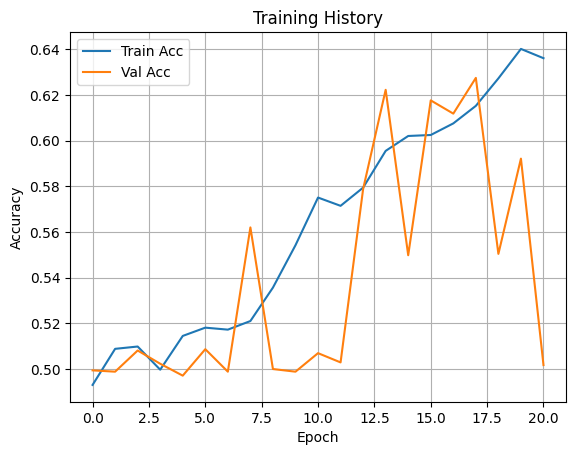

In [2]:
# === CNN Model Definition ===
def build_deep_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    x = Conv1D(32, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(64, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(128, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.4)(x)

    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === Build & Train ===
model = build_deep_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Epoch 1/30
216/216 [==============================] - 38s 142ms/step - loss: 0.7042 - accuracy: 0.5103 - val_loss: 0.7489 - val_accuracy: 0.4988
Epoch 2/30
216/216 [==============================] - 29s 133ms/step - loss: 0.6939 - accuracy: 0.5009 - val_loss: 0.7400 - val_accuracy: 0.4994
Epoch 3/30
216/216 [==============================] - 17s 77ms/step - loss: 0.6937 - accuracy: 0.5032 - val_loss: 0.6918 - val_accuracy: 0.5371
Epoch 4/30
216/216 [==============================] - 14s 65ms/step - loss: 0.6935 - accuracy: 0.4959 - val_loss: 0.6930 - val_accuracy: 0.5255
Epoch 5/30
216/216 [==============================] - 13s 58ms/step - loss: 0.6934 - accuracy: 0.4975 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 6/30
216/216 [==============================] - 12s 57ms/step - loss: 0.6935 - accuracy: 0.4942 - val_loss: 0.6929 - val_accuracy: 0.4994
Epoch 7/30
216/216 [==============================] - 13s 60ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6929 - val_accurac

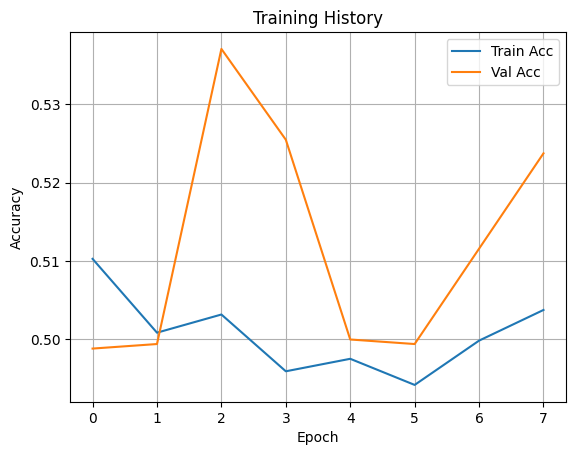

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     Dropout, MaxPooling1D, GlobalAveragePooling1D,
                                     Dense)
from tensorflow.keras import regularizers

def build_soft_dilated_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    x = Conv1D(32, 16, dilation_rate=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(64, 8, dilation_rate=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(128, 8, dilation_rate=4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 4, dilation_rate=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

    
model = build_soft_dilated_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Epoch 1/30
216/216 [==============================] - 20s 67ms/step - loss: 0.7099 - accuracy: 0.5026 - val_loss: 0.7131 - val_accuracy: 0.4977
Epoch 2/30
216/216 [==============================] - 15s 68ms/step - loss: 0.6974 - accuracy: 0.5112 - val_loss: 0.7052 - val_accuracy: 0.4994
Epoch 3/30
216/216 [==============================] - 15s 67ms/step - loss: 0.6961 - accuracy: 0.5074 - val_loss: 0.6980 - val_accuracy: 0.4983
Epoch 4/30
216/216 [==============================] - 13s 60ms/step - loss: 0.6940 - accuracy: 0.5174 - val_loss: 0.6974 - val_accuracy: 0.5104
Epoch 5/30
216/216 [==============================] - 14s 64ms/step - loss: 0.6935 - accuracy: 0.5167 - val_loss: 0.6961 - val_accuracy: 0.5017
Epoch 6/30
216/216 [==============================] - 13s 60ms/step - loss: 0.6925 - accuracy: 0.5170 - val_loss: 0.7415 - val_accuracy: 0.5006
Epoch 7/30
216/216 [==============================] - 15s 70ms/step - loss: 0.6924 - accuracy: 0.5243 - val_loss: 0.7109 - val_accuracy:

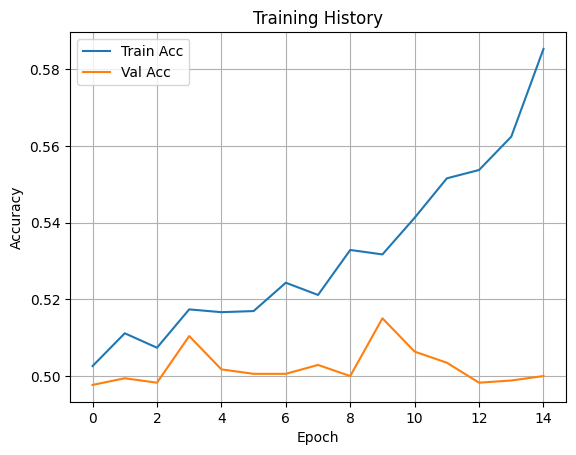

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU, Dropout, LeakyReLU
                                     MaxPooling1D, GlobalAveragePooling1D, Dense, Add)
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size, dilation_rate=1, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])  # Residual connection
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    return x

def build_hybrid_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    # Stage 1: Initial Conv Blocks
    x = Conv1D(32, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(64, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    # Stage 2: Soft-Dilated Layers with Residuals
    x = Conv1D(128, 8, padding='same', dilation_rate=2)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = residual_block(x, 128, 8, dilation_rate=2)
    x = MaxPooling1D(2)(x)

    # Stage 3: Deeper Layer
    x = Conv1D(256, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.4)(x)

    # GAP and Dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = build_hybrid_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_pred = model.predict(X_val).ravel()
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


Epoch 1/30
216/216 [==============================] - 38s 146ms/step - loss: 0.7156 - accuracy: 0.5029 - val_loss: 1.5476 - val_accuracy: 0.4994
Epoch 2/30
216/216 [==============================] - 31s 142ms/step - loss: 0.6964 - accuracy: 0.5133 - val_loss: 0.8418 - val_accuracy: 0.5000
Epoch 3/30
216/216 [==============================] - 31s 143ms/step - loss: 0.6933 - accuracy: 0.5265 - val_loss: 0.6922 - val_accuracy: 0.5191
Epoch 4/30
216/216 [==============================] - 31s 146ms/step - loss: 0.6928 - accuracy: 0.5194 - val_loss: 0.6926 - val_accuracy: 0.5313
Epoch 5/30
216/216 [==============================] - 31s 146ms/step - loss: 0.6917 - accuracy: 0.5319 - val_loss: 0.6910 - val_accuracy: 0.5174
Epoch 6/30
216/216 [==============================] - 32s 147ms/step - loss: 0.6906 - accuracy: 0.5354 - val_loss: 0.6980 - val_accuracy: 0.5017
Epoch 7/30
216/216 [==============================] - 29s 134ms/step - loss: 0.6857 - accuracy: 0.5519 - val_loss: 0.6918 - val_ac

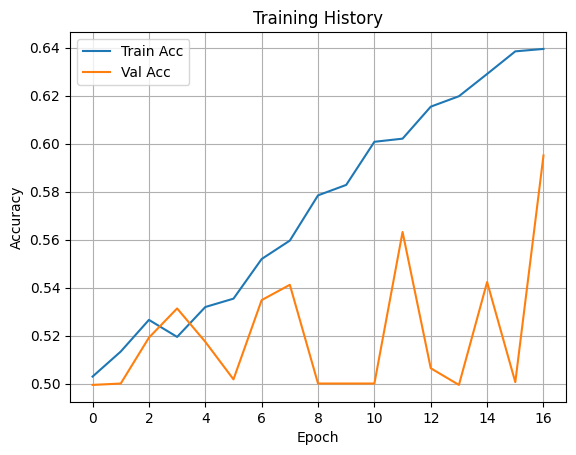

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU, Dropout, LeakyReLU,
                                     MaxPooling1D, GlobalAveragePooling1D, Dense, Add)
from tensorflow.keras.optimizers import Adam

def build_stronger_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(128, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(256, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(512, 4, padding='same')(x)   # new added layer
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model



model = build_stronger_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()